# How to work with ERA5 single levels on Earth Data Hub

***
This notebook will provide you guidance on how to access and use the `reanalysis-era5-single-levels.zarr` datset on Earth Data Hub.

The first goal is to compute the 2 metre temperature (t2m) anomaly for the month of October 2023, in the Germany area, against the 1981-2010 reference period. 

The second goal is to compute the t2m climatology (monthly means and standard deviations) in Berlin for the same reference period and compare it with the monthly averages of 2023.
***

## What you will learn:

* how to access and preview the dataset
* select and reduce the data
* plot the results

## Data access and preview
***

Xarray and Dask work together following a lazy principle. This means when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. A smart user will reduce the amount of data that needs to be downloaded before the computation takes place (e.g., when the `.compute()` or `.plot()` methods are called).

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically:

***

In [1]:
import xarray as xr

ds = xr.open_dataset(
    "s3://ecmwf-era5-single-levels/reanalysis-era5-single-levels.zarr",
    chunks={},
    engine="zarr",
)
ds

<xarray.Dataset>
Dimensions:     (valid_time: 735600, latitude: 721, longitude: 1440)
Coordinates:
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1940-01-01 ... 2023-11-30T23:00:00
Data variables:
    d2m         (valid_time, latitude, longitude) float16 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    t2m         (valid_time, latitude, longitude) float16 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float16 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float16 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float16 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2023-11-29T17:46 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

## Working with data

Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment. 

The structure of a workflow that uses EDH data looks like this:
1. data selection
2. (optional) data reduction
3. (optional) visualization

## 2 metre temperature: average October 2023 in Germany

### 1. Data selection

First, we perform a geographical selection corresponding to the Germany area. This greatly reduces the amount of data that will be downloaded from EDH. Also, we convert the temperature to `°C`.

In [2]:
t2m = ds.t2m.astype("float32") - 273.15
t2m.attrs["units"] = "C"
t2m_germany_area = t2m.sel(**{"latitude": slice(55, 47), "longitude": slice(5, 16)})
t2m_germany_area

<xarray.DataArray 't2m' (valid_time: 735600, latitude: 33, longitude: 45)>
dask.array<getitem, shape=(735600, 33, 45), dtype=float32, chunksize=(2880, 33, 44), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * longitude   (longitude) float64 5.0 5.25 5.5 5.75 ... 15.25 15.5 15.75 16.0
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1940-01-01 ... 2023-11-30T23:00:00
Attributes:
    units:    C

!NB: At this point, no data has been downloaded yet, nor loaded in memory.

Second, we further select the October 2023 month. This is, again, a lazy operation:

In [3]:
t2m_germany_area_october_2023 = t2m_germany_area.sel(valid_time="2023-10")
t2m_germany_area_october_2023

<xarray.DataArray 't2m' (valid_time: 744, latitude: 33, longitude: 45)>
dask.array<getitem, shape=(744, 33, 45), dtype=float32, chunksize=(480, 33, 44), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * longitude   (longitude) float64 5.0 5.25 5.5 5.75 ... 15.25 15.5 15.75 16.0
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 2023-10-01 ... 2023-10-31T23:00:00
Attributes:
    units:    C

At this point the selection is small enough to call `.compute()` on it. This will trigger the download of data from EDH and load it in memory. 

We can measure the time it takes:

In [4]:
%time

t2m_germany_area_october_2023 = t2m_germany_area_october_2023.compute()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.3 µs


The data was very small. This didn't take long!

### 2. Data reduction

Now that the data is loaded in memory, we can easily compute the october 2023 monthly mean:

In [5]:
t2m_germany_area_october_2023_monthly_mean = t2m_germany_area_october_2023.mean(dim="valid_time")
t2m_germany_area_october_2023_monthly_mean

<xarray.DataArray 't2m' (latitude: 33, longitude: 45)>
array([[13.325453 , 13.389966 , 13.424911 , ..., 12.257616 , 12.284496 ,
        12.304321 ],
       [13.614086 , 13.664152 , 13.679943 , ..., 12.537507 , 12.4921465,
        12.512643 ],
       [13.858366 , 13.903055 , 13.91448  , ..., 12.575477 , 12.505922 ,
        12.191089 ],
       ...,
       [13.5314245, 14.038129 , 14.431263 , ..., 10.0140505, 10.73885  ,
        11.996536 ],
       [14.110707 , 14.629511 , 15.010548 , ..., 11.550653 , 12.272733 ,
        12.732729 ],
       [14.843212 , 15.05759  , 15.260543 , ..., 13.064035 , 13.677259 ,
        13.871476 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * longitude  (longitude) float64 5.0 5.25 5.5 5.75 ... 15.25 15.5 15.75 16.0
    number     int64 0
    surface    float64 0.0

### 3. Visualization
Finally, we can plot the october 2023 montly mean on a map:

In [6]:
import display
import matplotlib.pyplot as plt

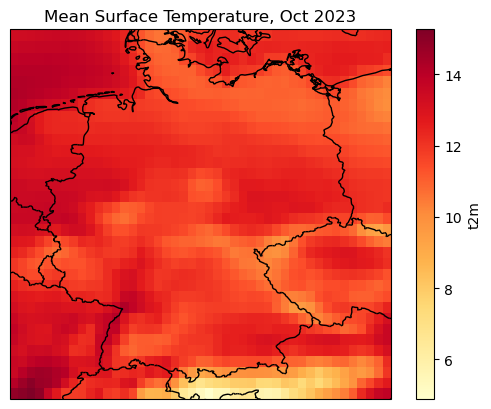

In [7]:
display.map(t2m_germany_area_october_2023_monthly_mean, vmax=None, cmap="YlOrRd", title="Mean Surface Temperature, Oct 2023")

## 2 metre temperature: October 2023 anomaly in Germany

Following the above schema we can compute the 2 metre temperature anomaly for the month of October 2023 against the 1981-2010 reference period, once again in Germany.

We fistly select the relevant months in the reference period:

In [8]:
t2m_germany_area_octobers_1981_2010 = t2m_germany_area.sel(valid_time=t2m_germany_area["valid_time.month"] == 10).sel(valid_time=slice("1981", "2010"))
t2m_germany_area_octobers_1981_2010

<xarray.DataArray 't2m' (valid_time: 22320, latitude: 33, longitude: 45)>
dask.array<getitem, shape=(22320, 33, 45), dtype=float32, chunksize=(744, 33, 44), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * longitude   (longitude) float64 5.0 5.25 5.5 5.75 ... 15.25 15.5 15.75 16.0
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1981-10-01 ... 2010-10-31T23:00:00
Attributes:
    units:    C

This is small enought to be computed in reasonable time:

In [9]:
%%time

t2m_germany_area_octobers_1981_2010 = t2m_germany_area_octobers_1981_2010.compute()

CPU times: user 9.15 s, sys: 2.69 s, total: 11.8 s
Wall time: 6.28 s


Now that the data is loaded in memory we can esily compute the 1981-2010 octobers mean:

In [10]:
t2m_germany_area_octobers_1981_2010_mean = t2m_germany_area_octobers_1981_2010.mean(dim="valid_time")

And finally the anomaly:

In [11]:
anomaly = t2m_germany_area_october_2023_monthly_mean - t2m_germany_area_octobers_1981_2010_mean
anomaly

<xarray.DataArray 't2m' (latitude: 33, longitude: 45)>
array([[1.2092018, 1.2420034, 1.2450457, ..., 1.3363085, 1.3735933,
        1.3998814],
       [1.3227825, 1.3358078, 1.3424721, ..., 1.5403643, 1.5236273,
        1.553174 ],
       [1.4189034, 1.4275789, 1.4437532, ..., 1.6468067, 1.6265469,
        1.5552645],
       ...,
       [2.8219347, 2.8525438, 3.018878 , ..., 3.6262593, 3.7644095,
        3.9092007],
       [2.9029655, 2.9343815, 3.0817842, ..., 3.53193  , 3.6636162,
        3.8030863],
       [3.0543375, 3.0173693, 3.09439  , ..., 3.6676264, 3.7267675,
        3.850441 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * longitude  (longitude) float64 5.0 5.25 5.5 5.75 ... 15.25 15.5 15.75 16.0
    number     int64 0
    surface    float64 0.0

We can plot the anomaly on a map:

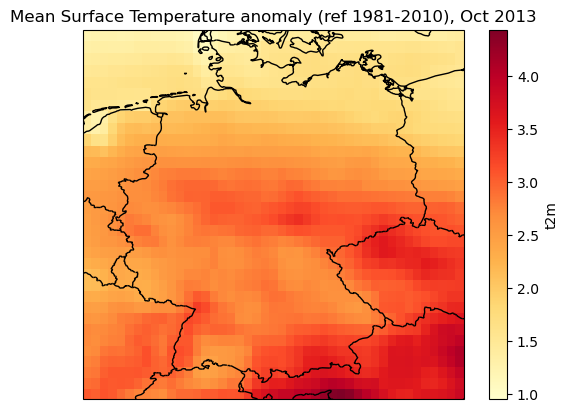

In [12]:
display.map(
    anomaly,
    vmax=None, 
    cmap="YlOrRd", 
    title="Mean Surface Temperature anomaly (ref 1981-2010), Oct 2013"
)

## 1981-2010 climatology vs 2023 montly mean

We will now compute the 2 metre temperature climatology (montly mean and standard deviation) in Berlin, over the reference period 1981-2010, and compare it with the 2023 monthly means.

We first select the closet data to Berlin:

In [13]:
%%time

t2m_Berlin = t2m.sel(**{"latitude": 52.5, "longitude": 13.4}, method="nearest")
t2m_Berlin

CPU times: user 3.46 ms, sys: 0 ns, total: 3.46 ms
Wall time: 3.45 ms


<xarray.DataArray 't2m' (valid_time: 735600)>
dask.array<getitem, shape=(735600,), dtype=float32, chunksize=(2880,), chunktype=numpy.ndarray>
Coordinates:
    latitude    float64 52.5
    longitude   float64 13.5
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1940-01-01 ... 2023-11-30T23:00:00
Attributes:
    units:    C

This is already small enought to be computed:

In [14]:
%%time

t2m_Berlin = t2m_Berlin.compute()

CPU times: user 34.2 s, sys: 9.87 s, total: 44.1 s
Wall time: 29.8 s


Now that the data is loaded in memory we can easily compute the climatology for the reference period 1981-2010:

In [15]:
t2m_Berlin_climatology_mean = t2m_Berlin.sel(valid_time=slice("1981", "2010")).groupby("valid_time.month").mean(dim="valid_time")
t2m_Berlin_climatology_std = t2m_Berlin.sel(valid_time=slice("1981", "2010")).groupby("valid_time.month").std(dim="valid_time")

We also compute the  monthly means for the year 2023:

In [16]:
t2m_Berlin_2023_monthly_means = t2m_Berlin.sel(valid_time="2023").resample(valid_time="1M").mean(dim="valid_time")
t2m_Berlin_2023_monthly_means

<xarray.DataArray 't2m' (valid_time: 11)>
array([ 4.1796923,  3.010704 ,  5.551641 ,  7.8618503, 13.801259 ,
       19.066559 , 19.860262 , 19.305855 , 18.504393 , 11.931021 ,
              nan], dtype=float32)
Coordinates:
    latitude    float64 52.5
    longitude   float64 13.5
    number      int64 0
    surface     float64 0.0
  * valid_time  (valid_time) datetime64[ns] 2023-01-31 2023-02-28 ... 2023-11-30
Attributes:
    units:    C

We can finally plot the climatology in Berlin for the 1981-2010 refrence period against the 2023 montly means:

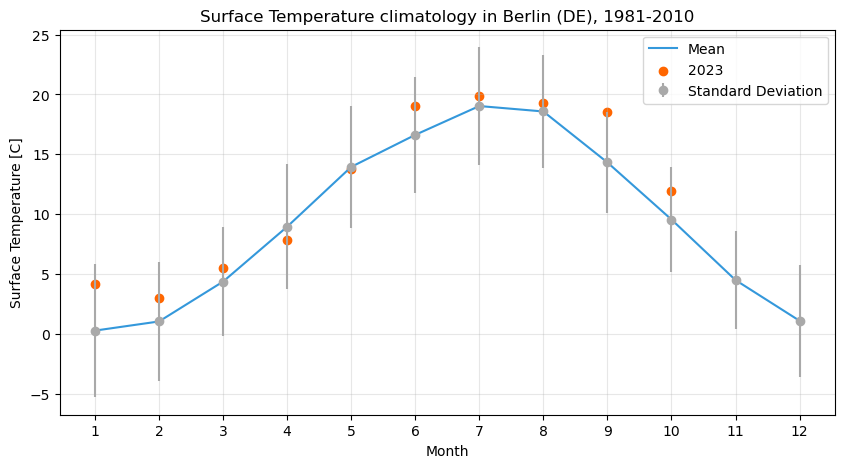

In [17]:
plt.figure(figsize=(10, 5))
t2m_Berlin_climatology_mean.plot(label="Mean", color="#3498db")
plt.errorbar(
    t2m_Berlin_climatology_mean.month, 
    t2m_Berlin_climatology_mean, 
    yerr=t2m_Berlin_climatology_std, 
    fmt="o", 
    label="Standard Deviation",
    color="#a9a9a9"
)
for month in range (1, 11):
    t2m_point = t2m_Berlin_2023_monthly_means.sel(valid_time=t2m_Berlin_2023_monthly_means["valid_time.month"]==month)
    label = None
    if month == 1:
        label = "2023"
    plt.scatter(month, t2m_point, color="#ff6600", label=label)
plt.title("Surface Temperature climatology in Berlin (DE), 1981-2010")
plt.xticks(t2m_Berlin_climatology_mean.month)
plt.xlabel("Month")
plt.ylabel("Surface Temperature [C]")
plt.legend()
plt.grid(alpha=0.3)
plt.show()